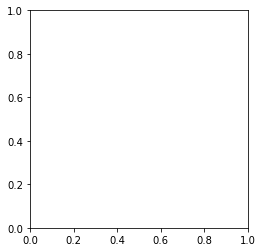

In [1]:
#%matplotlib widget
import matplotlib.pyplot as plt
plt.gca().set_aspect('equal')

import math
import numpy as np
import cv2
import glob
import json
import pickle
import os
from dataclasses import dataclass
import time

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


import plotly.graph_objects as go

def plot(
    points, connection_idx_list,
    line_color_list = None,
    show = True
) :
    '''
    points : np.ndarray
        shape : N, 2
    '''
    if not line_color_list :
        line_color_list = ['red'] * (len(connection_idx_list))

    fig = go.Figure(
        data = list(map(
            lambda i, j, c : go.Scatter(
                x = points[[i, j], 0],
                y = points[[i, j], 1],
                mode = 'lines+markers+text',
                line = dict(
                    color = c
                ),
                marker = dict(
                    color = c,
                    size = 2
                )
            ),
            connection_idx_list[:-1],
            connection_idx_list[1:],
            line_color_list
        ))
    )
    fig.update_yaxes(scaleanchor='x', scaleratio=1)

    if show :
        fig.show()

def plot3d(
    points, connection_idx_list,
    line_color_list = None,
    show = True
) :
    '''
    points : np.ndarray
        shape : N, 3
    '''
    if not line_color_list :
        line_color_list = ['red'] * (len(connection_idx_list))

    fig = go.Figure(
        data = list(map(
            lambda i, j, c : go.Scatter3d(x = points[[i, j], 0],
                y = points[[i, j], 1],
                z = points[[i, j], 2],
                mode = 'lines+markers+text',
                line = dict(
                    color = c
                ),
                marker = dict(
                    color = c,
                    size = 2
                )
            ),
            connection_idx_list[:-1],
            connection_idx_list[1:],
            line_color_list
        ))
    )

    max_range = np.max(np.ptp(points, axis=0))
    xmin, ymin, zmin = points.min(axis=0)

    fig.update_layout(scene=dict(aspectmode='cube'))
    fig.update_layout(scene=dict(
        xaxis = dict(range=[xmin-0.1, xmin + max_range+ 0.1]),
        yaxis = dict(range=[ymin-0.1, ymin + max_range+ 0.1]),
        zaxis = dict(range=[zmin-0.1, zmin + max_range+ 0.1])
    ))

    layout = go.Layout(
        scene = dict(
            camera = dict(
                eye = dict(x=-1, y = -1, z = 1)
            )
        )
    )
    fig.layout = layout
    if show :
        fig.show()

@dataclass
class AzureKinectLandmark :
    CONN_PATH_LIST = [
        25, 24, 23, 22, 0, 18, 19, 20, 21, 20, 19, 18, 0,
        1, 2, 11, 12, 13, 14, 15, 14, 13, 12, 11, 2, 
        4, 5, 6 ,7 , 8, 7, 6, 5, 4, 2, 3, 26,
        27, 30, 31, 30, 27, 28, 29
    ]

@dataclass
class OpenPoseLandmark :
    nose       : np.ndarray = None  # 0
    neck       : np.ndarray = None  # 1
    shoulder_r : np.ndarray = None  # 2
    elbow_r    : np.ndarray = None  # 3
    wrist_r    : np.ndarray = None  # 4
    shoulder_l : np.ndarray = None  # 5
    elbow_l    : np.ndarray = None  # 6
    wrist_l    : np.ndarray = None  # 7
    hip_r      : np.ndarray = None  # 8
    knee_r     : np.ndarray = None  # 9
    anklle_r   : np.ndarray = None  # 10
    hip_l      : np.ndarray = None  # 11
    knee_l     : np.ndarray = None  # 12
    ankle_l    : np.ndarray = None  # 13
    eye_r      : np.ndarray = None  # 14
    eye_l      : np.ndarray = None  # 15
    ear_r      : np.ndarray = None  # 16
    ear_l      : np.ndarray = None  # 17
    
    CONN_PATH_LIST = [16, 14, 0, 15, 17, 15, 0, 1, 2, 3, 4, 3, 2, 1, 5, 6, 7, 6, 5, 1, 8, 9, 10, 9, 8, 1, 11, 12, 13]
    CONN_N_COLOR_LIST = [
        [(16, 14), ()], [(14,  0)], [(0, 15)], [(15, 17)],
        [( 0,  1), (255,  40,  40)],
        [( 1,  8), (255,  50,  50)], [( 8,  9), (100, 255, 100)], [( 9, 10), (100, 255, 150)],
        [( 1, 11), (100, 255, 255)], [(11 ,12), ( 50,  50, 180)], [(12, 13), ( 50,  50, 255)],
        [( 1,  2), (200, 100,  50)], [( 2,  3), (150, 150,  50)], [( 3,  4), (150, 150,  50)],
        [( 1,  5), (200, 150,  50)], [( 5,  6), (100, 255, 100)], [( 6,  7), (100, 150, 100)],
    ]
    
    COLOR_LIST = [
        [255,   0,   0], [255,  85,   0], 
        [255, 170,   0], [255, 255,   0], [170, 255,   0],
        [ 85, 255,   0], [  0, 255,   0], [  0, 255,  85],
        [  0, 255, 170], [  0, 255, 255], [  0, 170, 255],
        [  0,  85, 255], [  0,   0, 255], [ 85,   0, 255], 
        [170,   0, 255], [255,   0, 255], [255,   0, 170], [255,   0,  85]]


    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
            [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
            [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
    edge_list = [[1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10], [1, 11], [11, 12], [12, 13], [1, 0], [0, 14], [14, 16], [0, 15], [15, 17],]

    @staticmethod
    def azurkinect2openpose(landmark) :
        nose       = landmark[27]
        neck       = landmark[3]
        shoulder_r = landmark[12]
        elbow_r    = landmark[13]
        wrist_r    = landmark[14]
        shoulder_l = landmark[5]
        elbow_l    = landmark[6]
        wrist_l    = landmark[7]
        hip_r      = landmark[22]
        knee_r     = landmark[23]
        anklle_r   = landmark[24]
        hip_l      = landmark[18]
        knee_l     = landmark[19]
        ankle_l    = landmark[20]
        eye_r      = landmark[30]
        eye_l      = landmark[29]
        ear_r      = landmark[31]
        ear_l      = landmark[29]
        
        return np.vstack([
            nose, neck,
            shoulder_r, elbow_r, wrist_r,
            shoulder_l, elbow_l, wrist_l,
            hip_r, knee_r, anklle_r,
            hip_l, knee_l, ankle_l,
            eye_r,
            eye_l,
            ear_r,
            ear_l,
        ]).copy()

    @staticmethod
    def mediapipe2openpose(landmark) :
        nose = landmark[0]
        neck = (landmark[11] + landmark[12]) / 2
        shoulder_r = landmark[12]
        elbow_r = landmark[14]
        wrist_r = landmark[16]
        shoulder_l = landmark[11]
        elbow_l = landmark[13]
        wrist_l = landmark[15]
        hip_r = landmark[24]
        knee_r = landmark[26]
        anklle_r = landmark[28]
        hip_l = landmark[23]
        knee_l = landmark[25]
        ankle_l = landmark[27]
        eye_r = landmark[5]
        eye_l = landmark[2]
        ear_r = landmark[8]
        ear_l = landmark[7]

        return np.vstack([
            nose, neck,
            shoulder_r, elbow_r, wrist_r,
            shoulder_l, elbow_l, wrist_l,
            hip_r, knee_r, anklle_r,
            hip_l, knee_l, ankle_l,
            eye_r,
            eye_l,
            ear_r,
            ear_l,
        ]).copy()
    
    @classmethod
    def plot2d(cls, landmark, img_size=(512, 512), connection = None) :
        if not connection : 
            connection = cls.CONN_PATH_LIST
        
        img = np.zeros([*img_size, 3], dtype=np.uint8)

        cv2.polylines(
            img,
            landmark,
            isClosed=True,
            color=None,
            thickness=1,
        )

    @classmethod
    def draw_bodypose(cls, canvas, candidate):
        stickwidth = 4

        for i in range(18):
            x, y = candidate[i][0:2]
            cv2.circle(canvas, (int(x), int(y)), 4, cls.colors[i], thickness=-1)
        
        for i, edge in enumerate(cls.edge_list):
            cur_canvas = canvas.copy()
            Y = candidate[edge, 0]
            X = candidate[edge, 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, cls.colors[i] )
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

        return canvas


    @classmethod
    def draw_from_3d(cls, candidate, img_size=(512, 512), ratio = 0.5):
        '''
        landmarks : np.ndarray
            shape : 18 x 3
        ratio :
            ratio of bounding boxes against img_size
        '''

        img = np.zeros([*img_size, 3], dtype=np.uint8)


        landmark_2d = candidate.copy() * 100
        landmark_2d = landmark_2d - landmark_2d.min(axis=0)

        bbox = landmark_2d.max(axis=0)

        cur_ratio = max( bbox[0] / img_size[0] , bbox[1] / img_size[1] )

        landmark_2d *= (ratio / cur_ratio)

        landmark_2d = landmark_2d.astype(int)[:, :2]

        # img_size : Ysize, Xsize
        # landmark : xcoord, ycoord

        # marginy, marginx
        margin = np.subtract(img_size, landmark_2d.max(axis=0)[::-1]).astype(int)

        translation = np.array([
            np.random.randint(0, margin[1]),
            np.random.randint(0, margin[0])
        ])

        landmark_2d += translation

        canvas = img
        candidate = landmark_2d

        stickwidth = 4

        for i in range(18):
            x, y = candidate[i][0:2]
            cv2.circle(canvas, (int(x), int(y)), 4, cls.colors[i], thickness=-1)
        
        for i, edge in enumerate(cls.edge_list):
            cur_canvas = canvas.copy()
            Y = candidate[edge, 0]
            X = candidate[edge, 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, cls.colors[i] )
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

        return canvas


def rpy2rm(roll, pitch, yaw) :
    '''
    fixed angle rotation values to rotation matrix
    same as euler angle with ZYX order
    '''
    c = np.cos
    s = np.sin
    r, p, y = roll, pitch, yaw
    Rz = np.array([
        [ c(y), -s(y), 0],
        [ s(y),  c(y), 0],
        [    0,     0, 1]
    ])
    Ry = np.array([
        [ c(p), 0, s(p)],
        [    0, 1,     0],
        [ -s(p), 0,  c(p)]
    ])
    Rx = np.array([
        [1,    0,     0],
        [0, c(r), -s(r)],
        [0, s(r),  c(r)]
    ])
    return Rz @ Ry @ Rx



DATA_DIR_PATH = "../azure_kinect_data"

DATA_DIR_PATH_LIST = glob.glob("../azure_kinect_data/*")


pose_data_dict = {}

for idx, data_dir_path in enumerate(DATA_DIR_PATH_LIST) :
    data_path_list = glob.glob(f"{data_dir_path}/*")

    pose_data_list = []

    for data_path in data_path_list :
        with open(data_path, "rb") as fp :
            landmark = np.array(
                pickle.load(fp)
            )
            landmark = landmark[:, :3]
        pose_data_list.append(landmark)
    
    pose_data_list = np.array(pose_data_list)
    pose_data_dict[os.path.basename(data_dir_path)] = pose_data_list


In [5]:
SAVE_ROOT_PATH = "../pose_images"

hor_rot_min = 0
hor_rot_max = 360
ver_rot_min = -10
ver_rot_max = 20

ratio_min = 0.5
ratio_max = 0.8
c = 0

for target_pose_name in pose_data_dict.keys() :
    SAVE_DIR_PATH = os.path.join(SAVE_ROOT_PATH, target_pose_name)
    os.makedirs(SAVE_DIR_PATH, exist_ok=True)

    for i, pose_data in enumerate(pose_data_dict[target_pose_name]) :

        for i in range(3) :
            landmark = OpenPoseLandmark.azurkinect2openpose(pose_data)

            ver_rot = np.random.randint(ver_rot_min, ver_rot_max)
            hor_rot = np.random.randint(hor_rot_min, hor_rot_max)

            rot_y_R = rpy2rm(0, np.deg2rad(hor_rot), 0)
            rot_x_R = rpy2rm(np.deg2rad(ver_rot), 0, 0)

            landmark = (rot_x_R @ rot_y_R @ landmark.T).T

            img = OpenPoseLandmark.draw_from_3d(
                landmark,
                ratio = np.random.uniform(ratio_min, ratio_max)
            )

            SAVE_PATH = os.path.join(SAVE_DIR_PATH, f"{str(time.time()).replace('.', '_')}.png")

            cv2.imwrite(SAVE_PATH, img)

            break
            #plt.imshow(img)
            #plt.show()



In [114]:
np.random.uniform(0.3, 0.4)

0.36752479916911

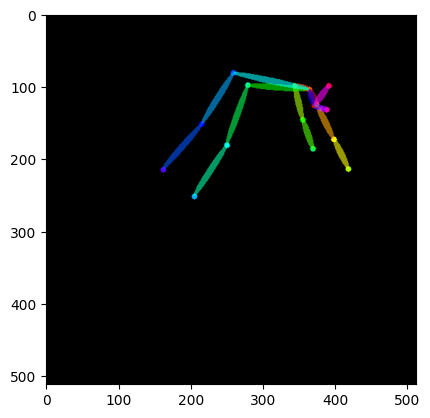

In [71]:



IDX = 10

hor_rot_min = 0
hor_rot_max = 360
ver_rot_min = -20
ver_rot_max = 50

ver_rot = np.random.randint(ver_rot_min, ver_rot_max)
hor_rot = np.random.randint(hor_rot_min, hor_rot_max)

landmark = OpenPoseLandmark.azurkinect2openpose(pose_data_list[IDX])

rot_y_R = rpy2rm(0, np.deg2rad(hor_rot), 0)
rot_x_R = rpy2rm(np.deg2rad(ver_rot), 0, 0)

landmark = (rot_x_R @ rot_y_R @ landmark.T).T

img = OpenPoseLandmark.draw_from_3d(landmark)
plt.imshow(img)
plt.show()

plot3d(
    landmark,
    OpenPoseLandmark.CONN_PATH_LIST
)